# Image compression with K-means

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.image as img 
from skimage import io
from sklearn.cluster import KMeans
import sys
import os
from sklearn.mixture import GaussianMixture
import matplotlib
%matplotlib inline

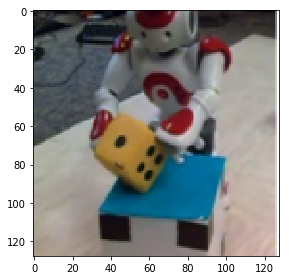

Lossy conversion from float64 to uint8. Range [2.3775262732417137, 254.6953125]. Convert image to uint8 prior to saving to suppress this warning.


Compressed image using k-means clustering


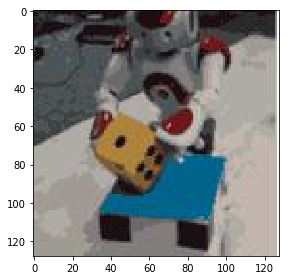

CPU times: user 1.97 s, sys: 358 ms, total: 2.33 s
Wall time: 1.56 s


In [2]:
%%time
##Self made K-means
#Function to find sample closest to chosen centroid
def sample_closest_centroid(sample, centroids):
    idx = np.zeros((sample.shape[0], 1))
    mat = np.zeros((sample.shape[0], len(centroids)))
    for i in range(len(centroids)):
        centroid_matrix = np.ones_like(sample)*centroids[i]
        distance = np.power(np.subtract(sample,centroid_matrix), 2)
        distance = np.sum(distance,axis=1).T
        mat[:,i] = distance
    idx = np.argmin(mat,axis=1)
    return idx

#Function to adjust the centroid to the center of the samples acquired
def adjust_centroids_mean(sample, idx, centroids):
    new_centroid = np.zeros((len(centroids),sample.shape[1]))
    for i in range(len(centroids)):
        mat = sample[idx == i]
        mat = np.sum(mat,axis=0)/len(mat)
        new_centroid[i,:] = mat
    
    return new_centroid

#K-Means clustering function for n-iteration
def kMeans_clustering(sample, centroids, iter_limit):
    for i in range(iter_limit):
        idx = sample_closest_centroid(sample, centroids)
        centroids = adjust_centroids_mean(sample, idx, centroids)
        
    return centroids, idx

#Function to reproduce the image
def compress_image(centroids, idx):
    centroids = np.array(centroids) 
    compressed_image = centroids[idx.astype(int),:]
    compressed_image = np.reshape(compressed_image, 
                                  (image.shape[0],image.shape[1],3))   
    
    
    io.imsave("Kmeans_NAORelease.jpg", compressed_image)
    compressed_image = io.imread("Kmeans_NAORelease.jpg")
    io.imshow(compressed_image)
    io.show()
    
#Main function
if __name__ == '__main__': 
    n_clusters=16
    image = io.imread('NAORelease.jpg')
    io.imshow(image)
    io.show()
    #image = image/255
    reshaped_image = image.reshape(image.shape[0]*image.shape[1],3)
    initial_centroids = random.sample(list(reshaped_image),n_clusters)
    centroids, idx = kMeans_clustering(reshaped_image, 
                                   initial_centroids,50)
   
    print("Compressed image using k-means clustering")
    compress_image(centroids,idx)
   

## Observation:

**1. The execution time varies for the fixed number of clusters and iterations. This is due to the random selection of the initial centroids which takes time to converge and even it converges to local optimum which can be clearly seen by slight changes in the resulting image along with the time if we execute n-times**

**2. One can think increasing the cluster number will make convergence fast but its not the case it increases the time due to number of clusters number of looping increases.**

**3. Also the runtime is directly proportional to the number of dimensions, as the number of dimension increases runtime also increases**

## Solution:

**1. We can take initial centroid from a uniformly distributed points which can speed up the initial covergence**

**2. Can have local beam search kind of system, instead of running all the cluster together we can run all the clusters parallel but this inturn increases the number of hardware usage.**

**3. We can do mini-batch excution in a parallel system or processor this will reduce the runtime but increases time in reproducing or merging the outputs.**

**4. Limit the iteration number and cluster number to an optimal value like 50 and 16 respectively but it varies with the application size and output requirements.**

**5. Analysing the time taken by sklearn module and own developed algorithm there is a much time difference so may be we can go with own package instead of using sklearn one**





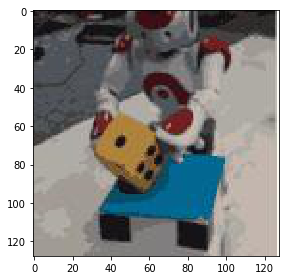

CPU times: user 5.42 s, sys: 4.63 s, total: 10 s
Wall time: 1.01 s


In [5]:
%%time
##Available K-means
# reading the image
image = io.imread('NAORelease.jpg')
 
# preprocessing
rows, cols = image.shape[0], image.shape[1]
image = image.reshape(rows * cols, 3)

# modelling

kMeans = KMeans(n_clusters = 16, max_iter=50)
kMeans.fit(image)

# getting centers and labels
centers = np.asarray(kMeans.cluster_centers_, dtype=np.uint8)
labels = np.asarray(kMeans.labels_, dtype = np.uint8)
labels = np.reshape(labels, (rows, cols))

# reconstructing the image
newImage = np.zeros((rows, cols, 3), dtype=np.uint8)
for i in range(rows):
    for j in range(cols):
            # assinging every pixel the rgb color of their label's center
            newImage[i, j, :] = centers[labels[i, j], :]
io.imsave("sklearn_compressed.jpg", newImage)

compressed_image = io.imread("sklearn_compressed.jpg")
io.imshow(compressed_image)
io.show()


In [6]:

info = os.stat('NAORelease.jpg')
print("size of image before running K-mean algorithm: ",info.st_size/1024,"KB")
info = os.stat('Kmeans_NAORelease.jpg')
print("size of image after running self developed K-mean algorithm: ",info.st_size/1024,"KB")
info = os.stat('sklearn_compressed.jpg')
print("size of image after running K-mean algorithm using sklearn: ",info.st_size/1024,"KB")




size of image before running K-mean algorithm:  13.98828125 KB
size of image after running self developed K-mean algorithm:  3.7685546875 KB
size of image after running K-mean algorithm using sklearn:  3.77734375 KB


## Analysing Both the algorithm
**1. Time taken by the sklearn algorithm is too high compare to the self developed one**

**2. Sklearn has compressed the image to less size compare to self developed one but it is negligible.**

**3. Sklearn more or less gives the same result whereas the self developed algorithm has a very little changes each time when it is executed**

# Mixture of Gaussian, EM-Algorithm



## Dataset 1

In [6]:
#Function to plot ellipse
def plot_ellipse(data, idx_value, k, title):
    
    col = ["g", "b", "r", "m", "c", "y"]
    plt.figure(figsize=(15,10))
    sub_plot = plt.subplot(1,1,1)
    for i in range(k):
        mat = data[idx_value==i] 
        #PCA Method to find ellipse axes
        mean = np.asarray(np.mean(mat,axis=0))        
        cov = np.cov(mat.T)
        eig_val,eig_vec = np.linalg.eigh(cov)
        major_axis = np.max(eig_val)
        minor_axis = np.min(eig_val)
        major_vec = eig_vec[:,np.argmax(eig_val)]
        angle = np.arctan(major_vec[1]/major_vec[0])
       
        ellipse = matplotlib.patches.Ellipse(mean,1*major_axis,1*minor_axis,
                                             np.rad2deg(angle),edgecolor=col[i+1],facecolor='none')
        ellipse.set_alpha(1)
        sub_plot.add_artist(ellipse)
        ellipse = matplotlib.patches.Ellipse(mean,3*major_axis,3*minor_axis,
                                             np.rad2deg(angle),edgecolor=col[i+1],facecolor='none')
        ellipse.set_alpha(1)
        sub_plot.add_artist(ellipse)
        ellipse = matplotlib.patches.Ellipse(mean,5*major_axis,5*minor_axis,
                                             np.rad2deg(angle),edgecolor=col[i+1],facecolor='none')
        ellipse.set_alpha(1)
        sub_plot.add_artist(ellipse)
        plt.scatter(mat[:,0],mat[:,1], c=col[i+1], label = "cluster "+str(i))
        
    outliers = data[idx_value==-1] 
    plt.scatter(outliers[:,0],outliers[:,1], c=col[0], label = "Outliers")
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    plt.legend(loc="upper left")
    plt.grid()
    plt.title(title)
    plt.show() 


#Function for EM Algorithm
def EM_algorithm(data, k):
    
   
    plt.figure(figsize=(15,10))
    plt.scatter(data[:,0], data[:,1], c="k",label="data points")
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    plt.legend(loc="upper left")
    plt.title("Initial distribution")
    plt.grid()
    plt.show()
    
    clusters_n = k
    mog = GaussianMixture(n_components = clusters_n, init_params='kmeans') 

    mog.fit(data) 
    labels = mog.predict(data)    
    prob = mog.predict_proba(data)
    max_value = np.max(prob, axis=1)
    idx_value = np.argmax(prob,axis=1)
    
    #Soft assignment using probability
    for idx, i in enumerate(max_value):
        if i<0.9:
            idx_value[idx] = -1            
        else:
            pass
        
    plot_ellipse(data, idx_value, k, "Soft assignment")  
    plot_ellipse(data, labels, k, "Hard assignment")          
    
    
    

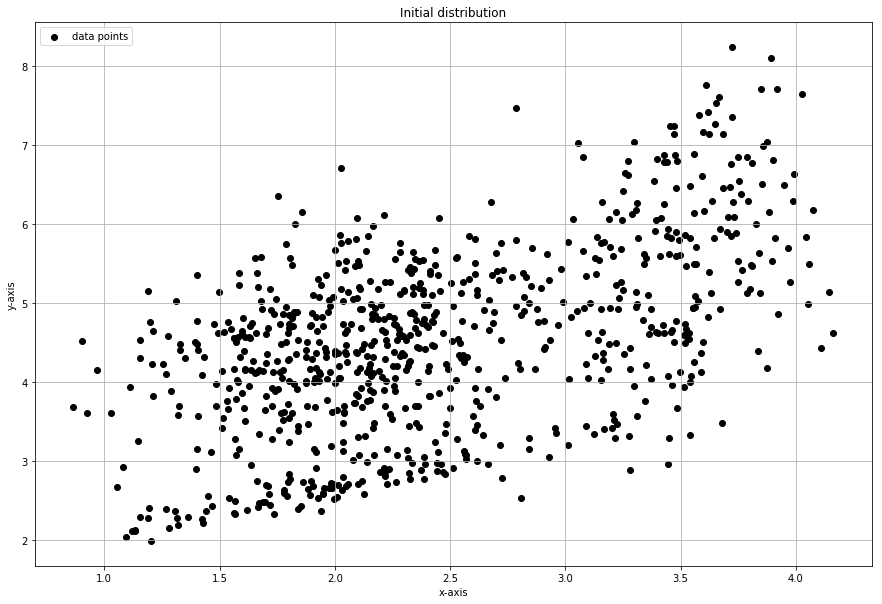

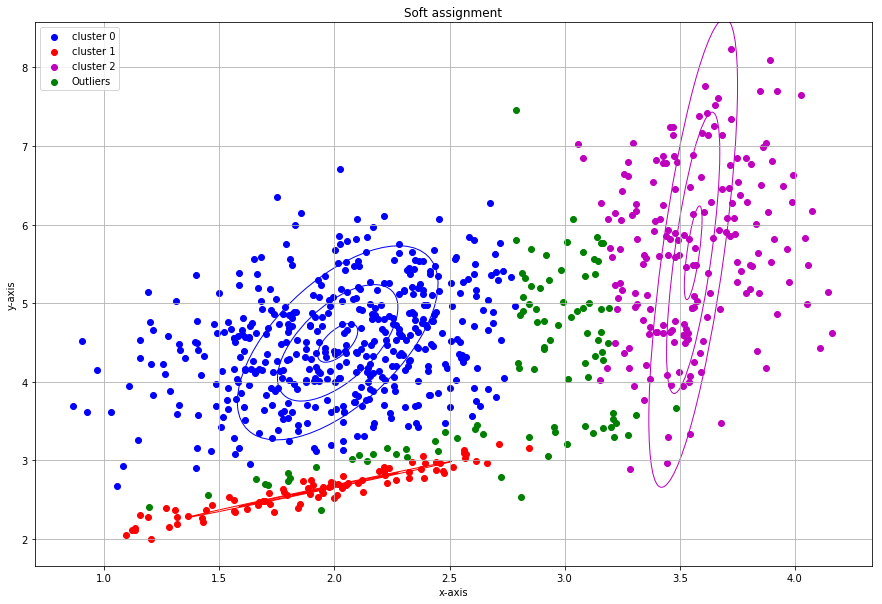

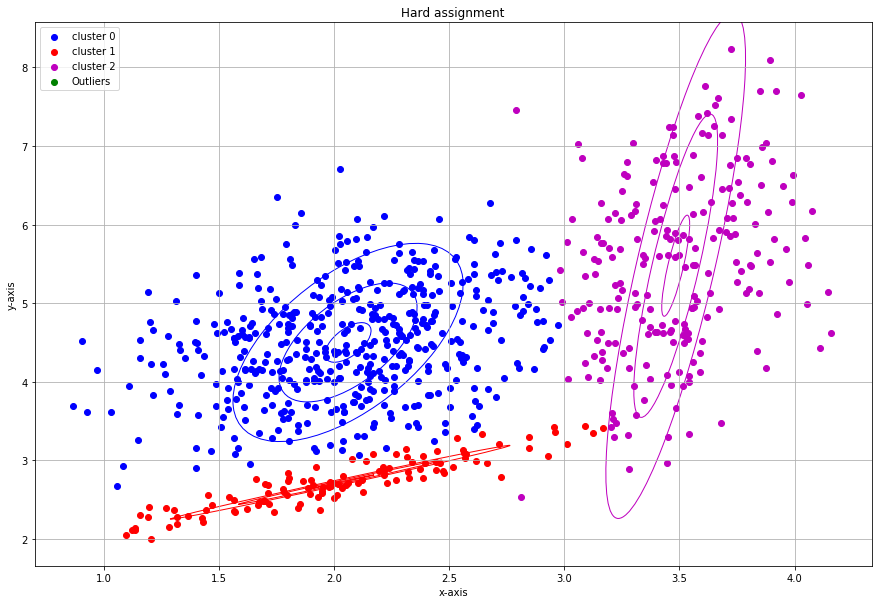

In [7]:
# Make some random data in 2D.
np.random.seed(150)
means = np.array([[2.1, 4.5],
                  [2.0, 2.7],
                  [3.5, 5.6]])
covariances = [np.array([[0.20, 0.10], [0.10, 0.60]]),
               np.array([[0.35, 0.22], [0.22, 0.15]]),
               np.array([[0.06, 0.05], [0.05, 1.30]])]
amplitudes = [5, 1, 2]
factor = 100
data = np.zeros((1, 2))
for i in range(len(means)):
    data = np.concatenate([data,
         np.random.multivariate_normal(means[i], covariances[i],
                                           size=factor * amplitudes[i])])
data = data[1:, :]
EM_algorithm(data, 3)

## Dataset2

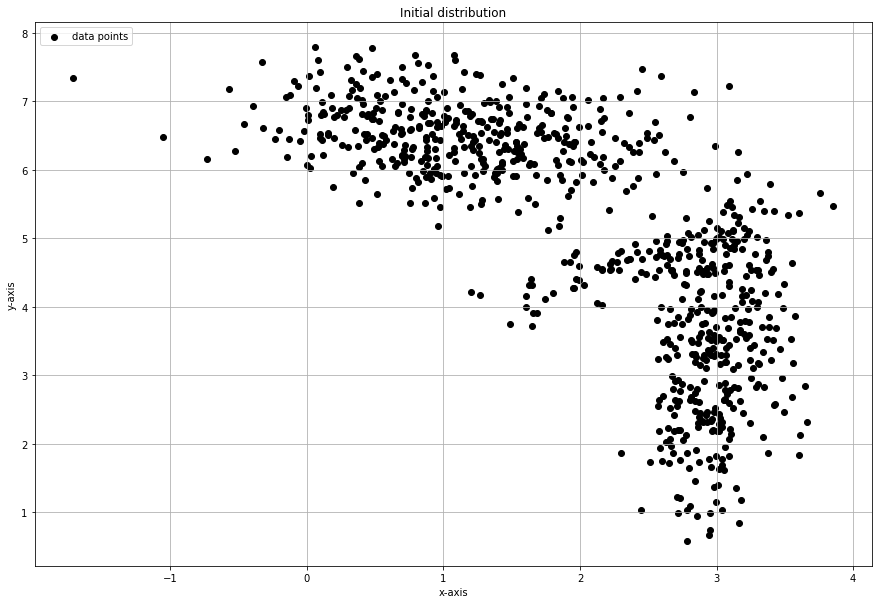

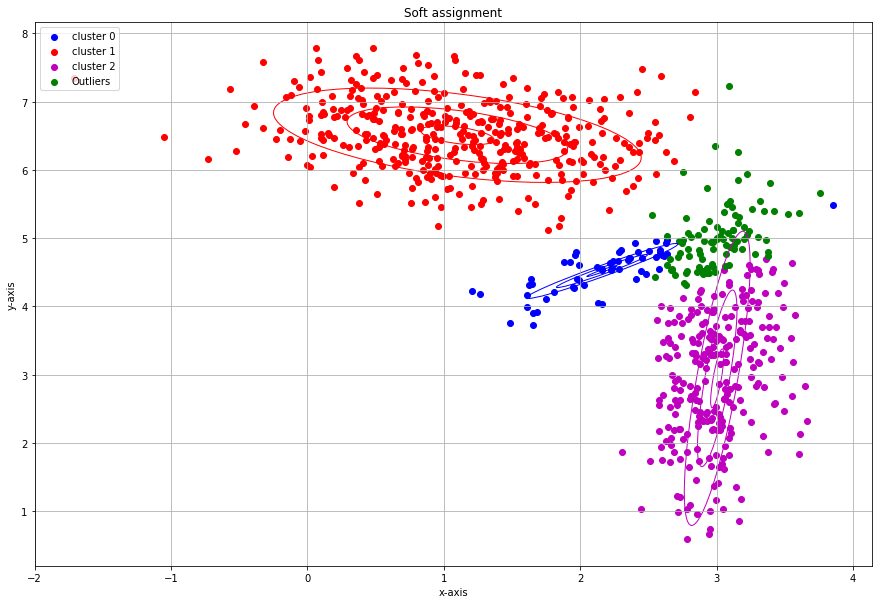

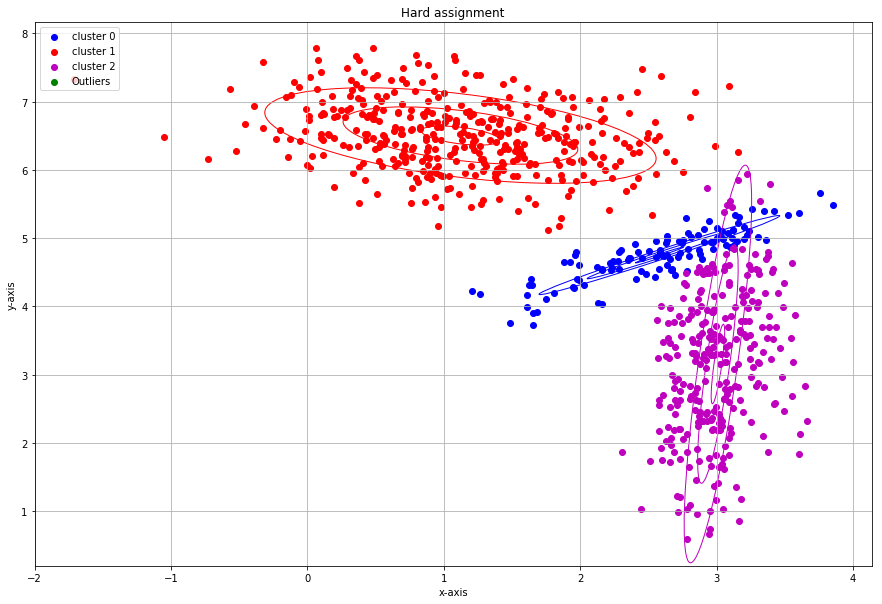

In [8]:
# Make some random data in 2D.
np.random.seed(150)
means = np.array([[1.1, 6.5],
                  [2.5, 4.7],
                  #[3.0, 2.6],
                  [3.0, 3.3]])
covariances = [np.array([[0.55, -0.10], [-0.10, 0.25]]),
                   np.array([[0.35, 0.22], [0.22, 0.20]]),
                   #np.array([[0.06, 0.05], [0.05, 1.30]]),
                   np.array([[0.06, 0.05], [0.05, 1.30]])]
amplitudes = [4, 1, 3]
factor = 100

data = np.zeros((1, 2))
for i in range(len(means)):
    data = np.concatenate([data,
          np.random.multivariate_normal(means[i], covariances[i],
                                                size=factor * amplitudes[i])])
data = data[1:, :]
EM_algorithm(data, 3)

## Summary

1. Plotted both hard and soft assignments. In soft assignments the probability value 0.9 to 1 is taken in respective cluster where the probability less than 0.9 are considered as outliers for all the clusters.

2. Plotted ellipsoids by calculating eigen vector so that we get the direction about maximum changes in the cluster which decided the major axes. Minnor axis is the last vector in which direction there is minimal change.